In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.layers import Dropout,Dense,Flatten,Conv2D,GlobalAveragePooling2D,AveragePooling2D
from keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import os 
import glob 
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


In [14]:
EPOCHS=20
BATCH_SIZE=32
LABELS=['without_mask','with_mask']

# return the images as arrays with their labels from the directory
# MobileNetv2 inputs images of size (224,224) 
def prepare_dataset(root_directory,size):
  image_list,labels_list=[],[]
  for i in LABELS:
    temp_dir=root_directory+"/"+i+"/*"
    for j in glob.glob(temp_dir):
      temp_img=load_img(j,target_size=size)
      temp_img=img_to_array(temp_img)
      image_list.append(temp_img)
      labels_list.append(i)
      
      
  return image_list,labels_list

# converting labels to categorical variables
def binarizer_labels(labels):
  lb=LabelBinarizer()
  binary_labels=lb.fit_transform(labels)
  binary_labels=to_categorical(binary_labels)
  return binary_labels

# Training the mobilenetv2 model with imagenet weight and saving the best model
def train_mobnetv2(train_data,valid_data):
  base_model=MobileNetV2(input_shape=(224,224,3),include_top=False,
                         weights="imagenet")
  upper_model=base_model.output
  upper_model = base_model.output
  upper_model = AveragePooling2D(pool_size=(7,7))(upper_model)
  upper_model = Flatten()(upper_model)
  upper_model = Dense(128, activation="relu")(upper_model)
  upper_model = Dropout(0.5)(upper_model)
  upper_model = Dense(2, activation="softmax")(upper_model)

  model=Model(inputs=base_model.input,outputs=upper_model)

  # We don't want it to train base model layers again as it is pretrained
  for i in base_model.layers:
    i.trainable=False
  
  # To saved the best model of all epochs by monitoring validation loss (min val_loss)
  checker=ModelCheckpoint(save_best_only=True,monitor="val_loss",filepath="mask_model.h5")
  # Early stopping incase it overfits the data
  early_stop=EarlyStopping(monitor="val_loss",min_delta=0.001,patience=5)
  
  optim=Adam(learning_rate=1e-4)
  model.compile(optimizer=optim,loss="binary_crossentropy",
                metrics=['accuracy'])
  model_history=model.fit(train_data,epochs=EPOCHS,batch_size=BATCH_SIZE,
                           validation_data=valid_data,validation_batch_size=BATCH_SIZE,
                           callbacks=[checker,early_stop])
  return model_history

In [11]:
images,labels=[],[]
current_dir="/content/drive/My Drive/DataMask2"
images,labels=prepare_dataset(current_dir,size=(224,224))
images=np.array(images,dtype="float32")
labels=binarizer_labels(labels) 
labels=np.array(labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [12]:
# Spliting into training and test set with augmentation 

(Xtrain,Xtest,ytrain,ytest)=train_test_split(images,labels,
                                               test_size=0.2,shuffle=True)
train_datagen = ImageDataGenerator(rescale=1.0/255,rotation_range=20,
                                    width_shift_range=0.2,height_shift_range=0.2,
                                    shear_range=0.15,zoom_range=0.15,
                                    horizontal_flip=True,fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Data with augmentation
training_data=train_datagen.flow(Xtrain,ytrain,batch_size=BATCH_SIZE)
validation_data=validation_datagen.flow(Xtest,ytest,batch_size=BATCH_SIZE)

In [15]:
# Training the data
model=train_mobnetv2(training_data,validation_data)

Epoch 1/20
96/96 [==============================] - 161s 2s/step - loss: 0.3555 - accuracy: 0.8434 - val_loss: 0.1261 - val_accuracy: 0.9661
Epoch 2/20
96/96 [==============================] - 161s 2s/step - loss: 0.1313 - accuracy: 0.9527 - val_loss: 0.0852 - val_accuracy: 0.9726
Epoch 3/20
96/96 [==============================] - 167s 2s/step - loss: 0.0940 - accuracy: 0.9677 - val_loss: 0.0673 - val_accuracy: 0.9739
Epoch 4/20
96/96 [==============================] - 163s 2s/step - loss: 0.0788 - accuracy: 0.9713 - val_loss: 0.0644 - val_accuracy: 0.9739
Epoch 5/20
96/96 [==============================] - 162s 2s/step - loss: 0.0735 - accuracy: 0.9742 - val_loss: 0.0695 - val_accuracy: 0.9700
Epoch 6/20
96/96 [==============================] - 164s 2s/step - loss: 0.0672 - accuracy: 0.9749 - val_loss: 0.0544 - val_accuracy: 0.9778
Epoch 7/20
96/96 [==============================] - 169s 2s/step - loss: 0.0631 - accuracy: 0.9759 - val_loss: 0.0531 - val_accuracy: 0.9765
Epoch 8/20
96

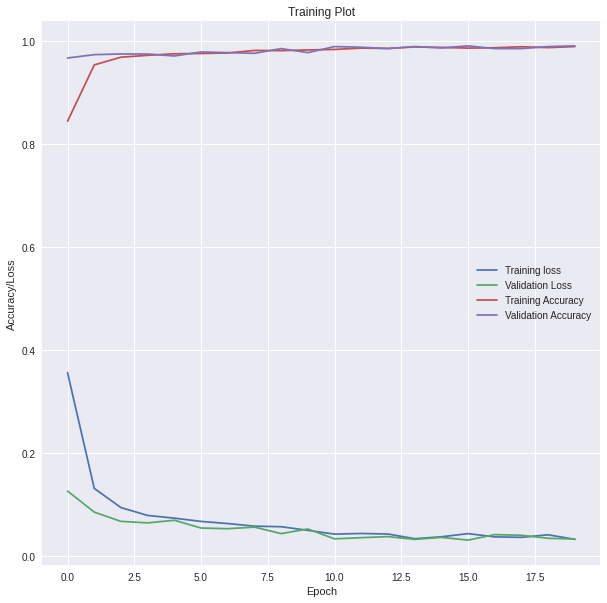

In [16]:
# Plot of the accuracy and loss with each epoch

plt.figure(figsize=(10,10))
plt.style.use('seaborn')
epoch_array=np.arange(0,EPOCHS)
plt.plot(epoch_array,model.history['loss'],label="Training loss")
plt.plot(epoch_array,model.history['val_loss'], label="Validation Loss")
plt.plot(epoch_array,model.history['accuracy'], label="Training Accuracy")
plt.plot(epoch_array,model.history['val_accuracy'],label="Validation Accuracy")
plt.title("Training Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend()

In [17]:

# Face Detection model from cv2 library
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+
                                    "haarcascade_frontalface_alt2.xml")
# After trying the default,alt and alt2 models, alt2 seemed to work the best

mask_model = load_model("mask_model.h5") # Loading mask detection model saved earlier

def face_mask_detector(frame):
  
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
  # Comverting it into Grayscale so that it runs quicker
  faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(60, 60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
  color_dict={"With Mask":(0, 255, 0),"Without Mask":(0, 0, 255)}
  faces_frame_list=[] # List of faces detected
  preds=[] # Prediction for each face
  for (x, y, w, h) in faces:
      face_frame = frame[y:y+h,x:x+w]
      face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
      face_frame = cv2.resize(face_frame, (224, 224)) 
      face_frame = img_to_array(face_frame)
      face_frame = np.expand_dims(face_frame, axis=0)
      face_frame =  preprocess_input(face_frame) 
      # Preprocessing for mask_model which has mobilenetv2 as its base
      faces_frame_list.append(face_frame)
      if len(faces_frame_list)>0:
          preds = mask_model.predict(faces_frame_list)
      for pred in preds:
          (mask, withoutMask) = pred 
          # returns values for both labels. prediction would be the one which is largest
      if mask > withoutMask:
        label = "With Mask"  
      else:
        label= "Without Mask"
      color = color_dict[label] # Green for With mask and red otherwise
      label = "{}: {:.1f}%".format(label, max(mask, withoutMask) * 100)
      # Printing the label with confidence acquired from predicting
      cv2.putText(frame, label, (x, y- 10),cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
      cv2.rectangle(frame, (x, y), (x + w, y + h),color, 3) # Drawing the box over the face

  return frame

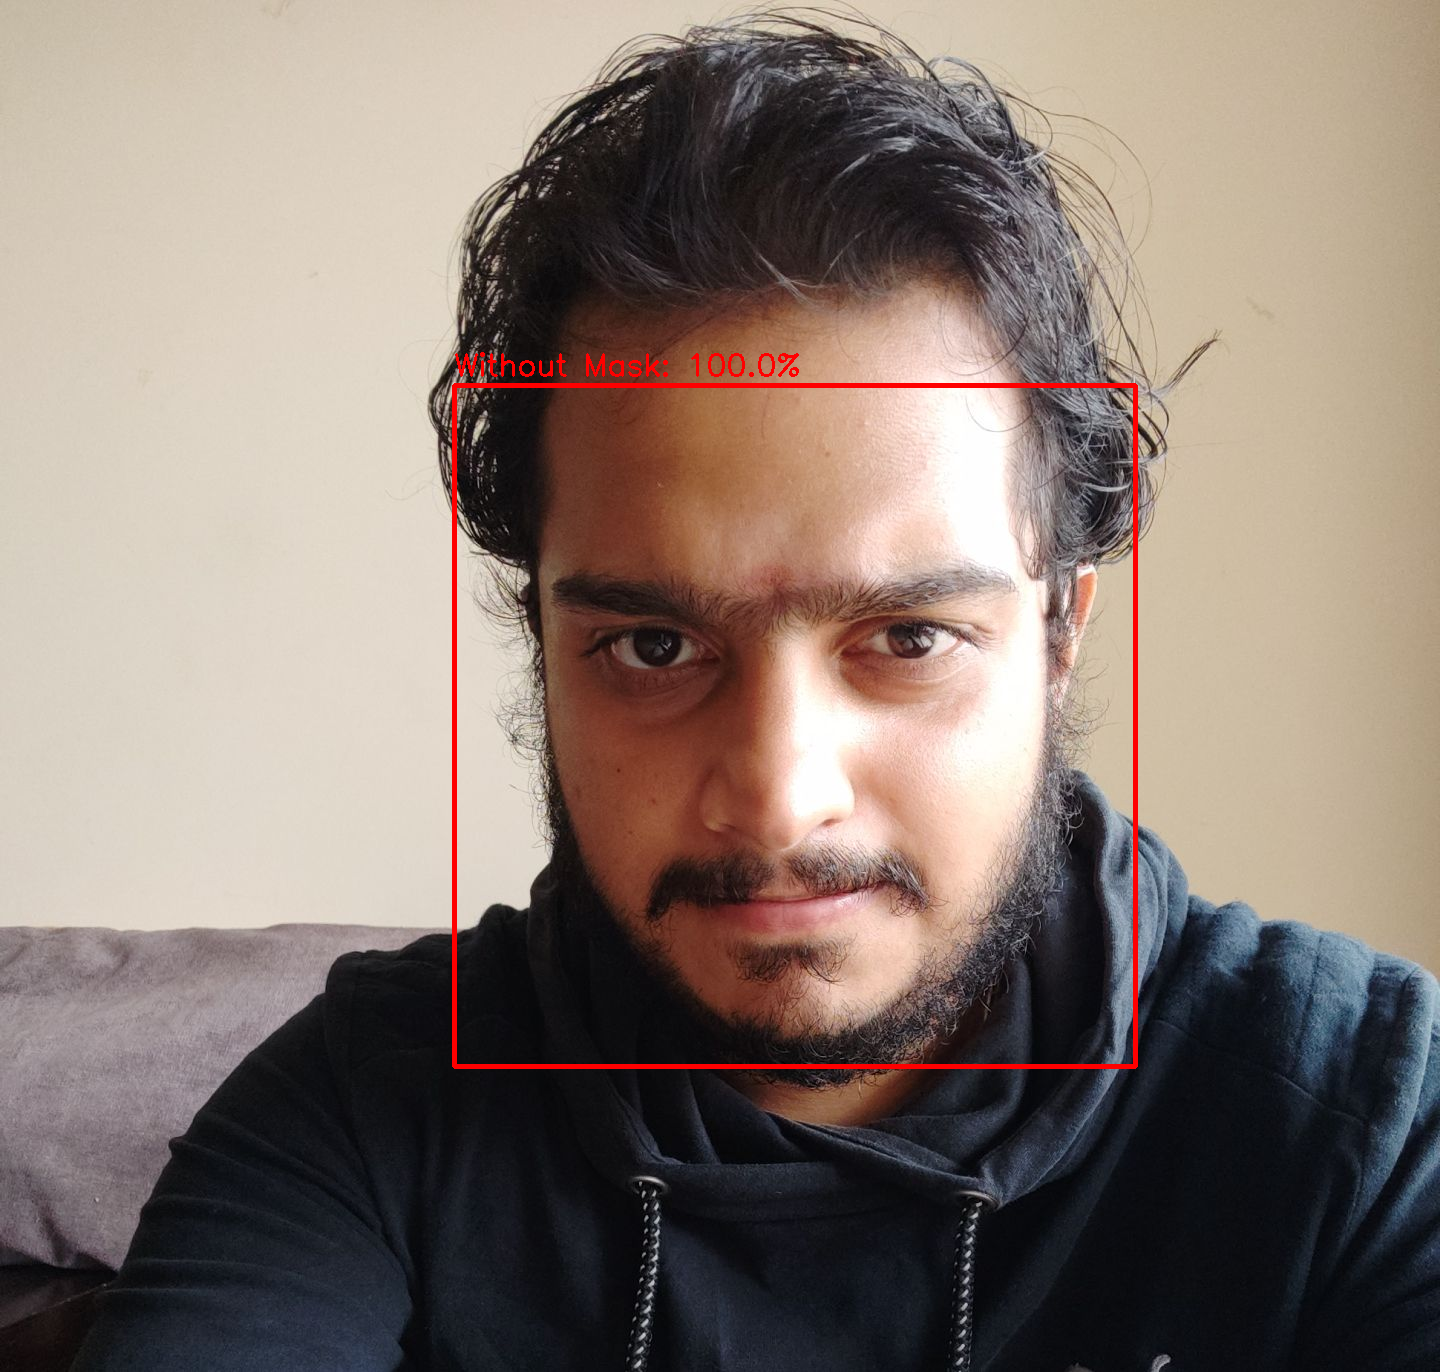

In [18]:
test_image=cv2.imread('/content/drive/My Drive/Without mask test.jpg')
result=face_mask_detector(test_image)
cv2_imshow(result)

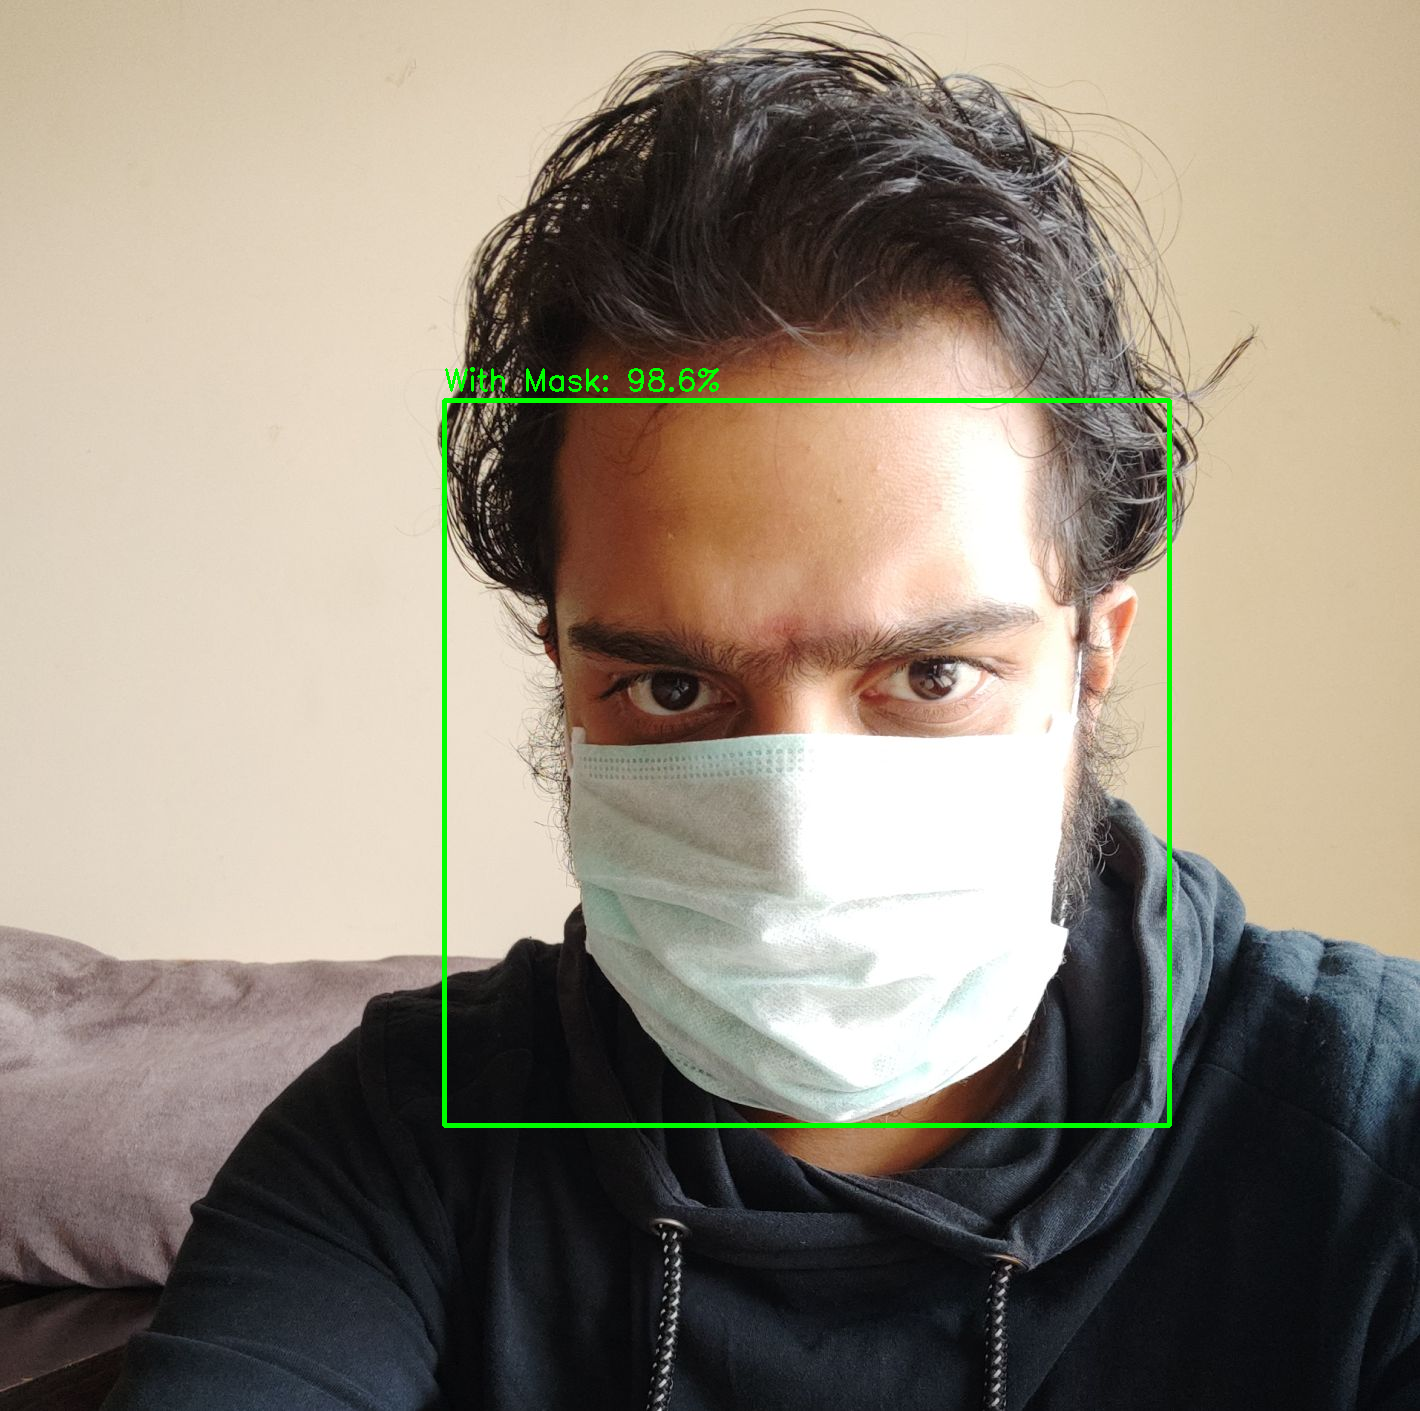

In [19]:
test_image=cv2.imread('/content/drive/My Drive/With mask test.jpg')
result=face_mask_detector(test_image)
cv2_imshow(result)

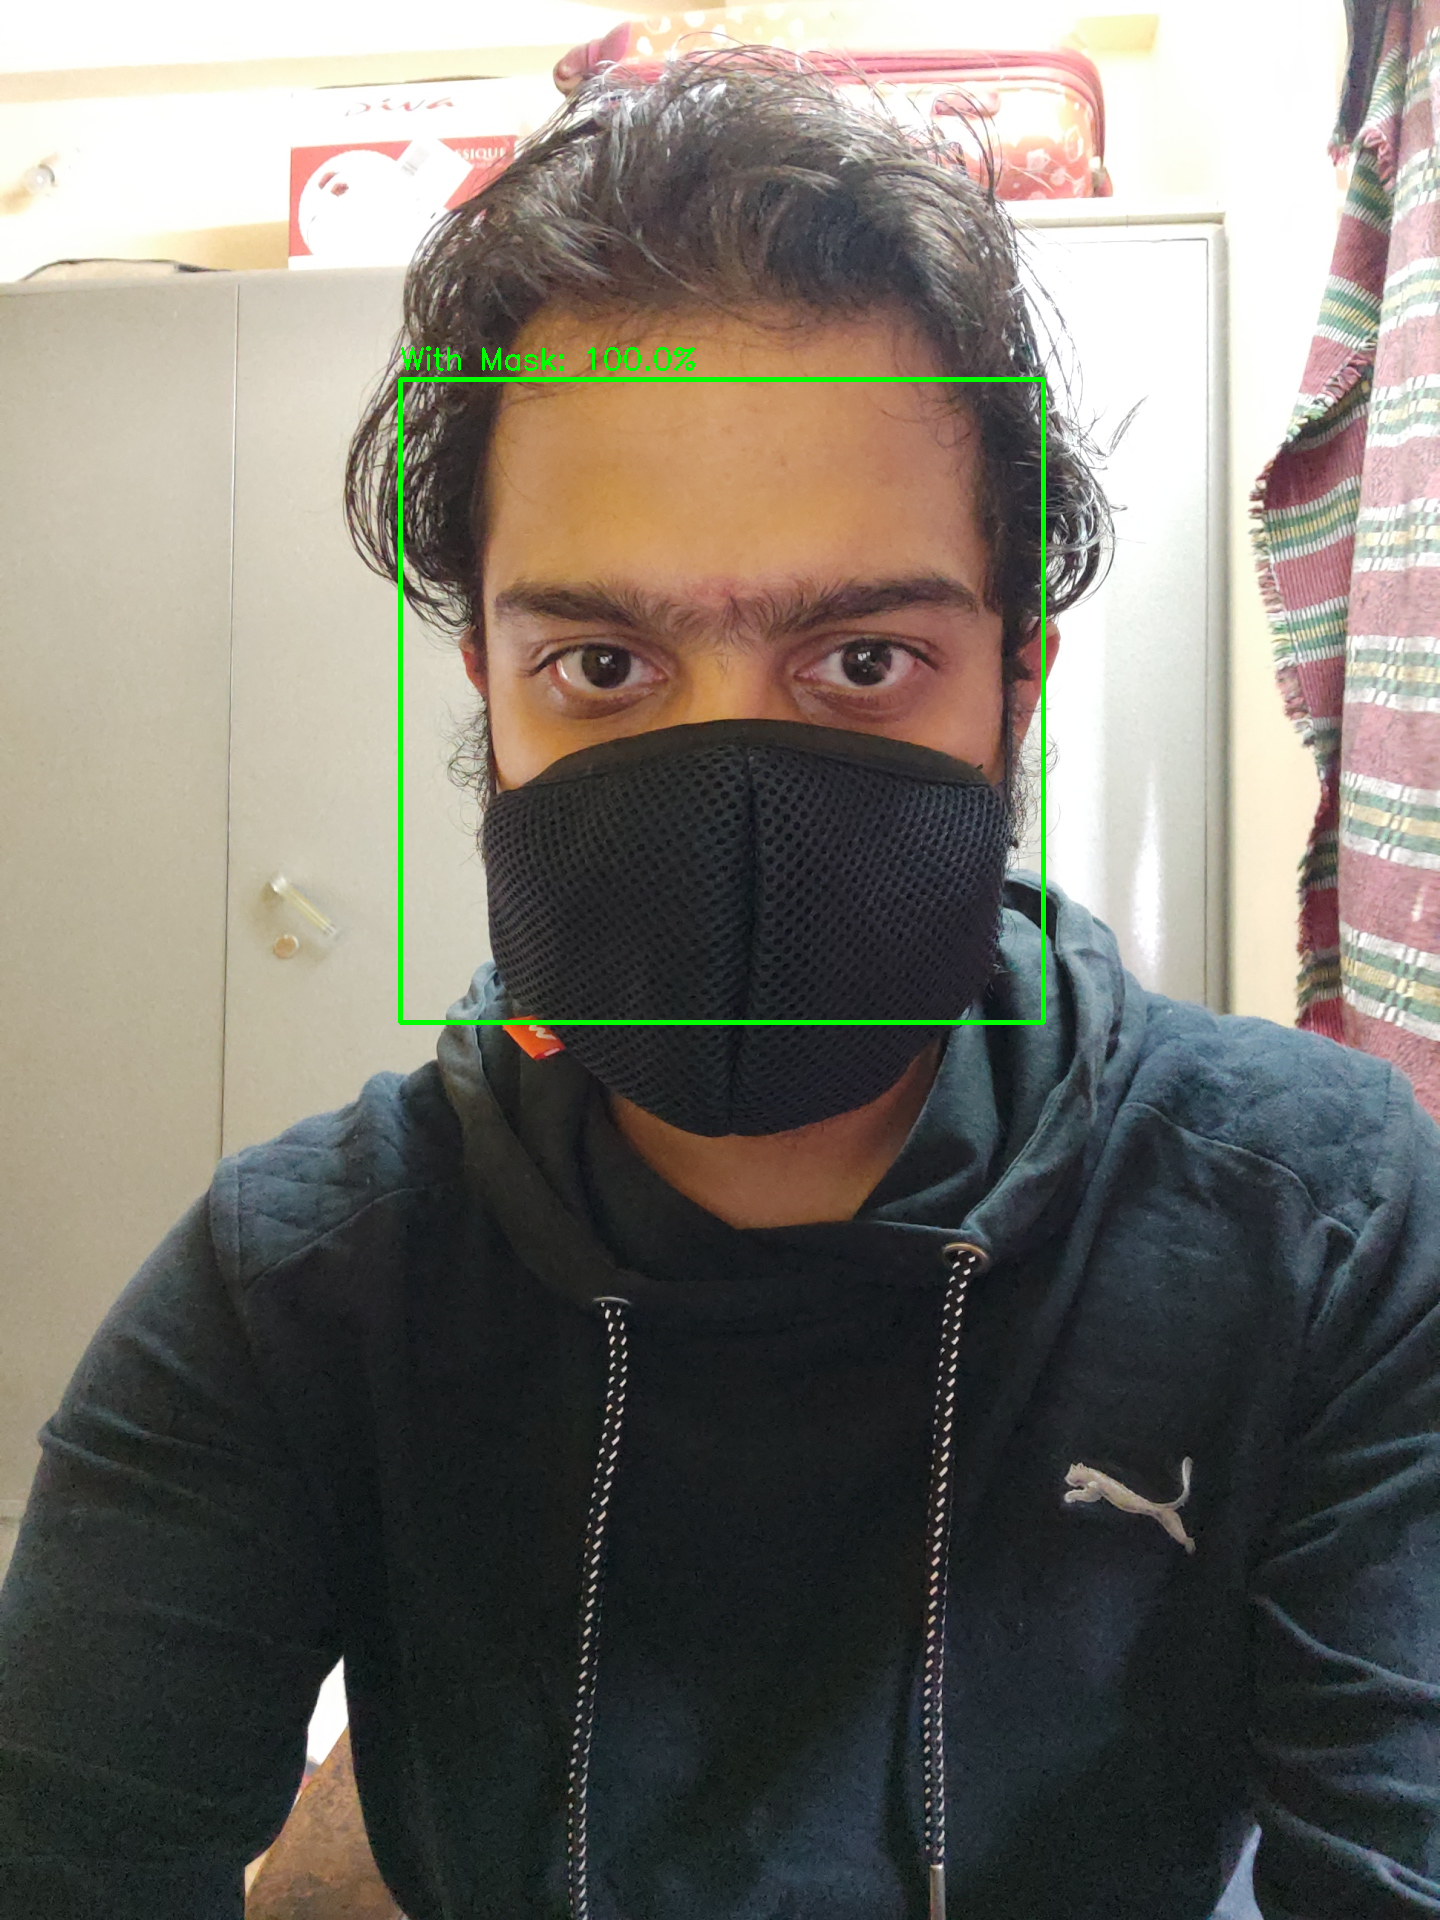

In [20]:
test_image=cv2.imread('/content/drive/My Drive/Black Mask test.jpg')
result=face_mask_detector(test_image)
cv2_imshow(result)